In [2]:
from qaravan.tensorQ import *
from qaravan.core import *

# Testing thermal noise simulation 

In [2]:
t1 = 1000
t2 = 1000
one_qubit_time = 1
two_qubit_time = 5
nm = QubitNoise(t1, t2, one_qubit_time, two_qubit_time)

In [3]:
gate_list = [H(0), CNOT([1,0], 3), CNOT([2,1], 3)]
circ = Circuit(gate_list, 3)
print(circ)

H gate on site(s) [0] 
bottom heavy CNOT2 gate on site(s) [0, 1] 
bottom heavy CNOT2 gate on site(s) [1, 2]


In [ ]:
sim = DensityMatrixSim(circ, nm=nm)
sim.run()
print(sim)  # dominant term should be Bell pair with some coherent error

100%|██████████| 3/3 [00:00<?, ?it/s]

0.9624 * (-0.7121|000⟩ + -0.7020|111⟩)
 0.0253 * (-0.7020|000⟩ + 0.7121|111⟩)
 0.0049 * (1.0000|011⟩)
 0.0025 * (1.0000|100⟩)
 0.0024 * (1.0000|110⟩)
 0.0024 * (1.0000|101⟩)


In [ ]:
local_ops = [pauli_Z, pauli_Z, pauli_Z]
sim.local_expectation(local_ops) # should be close to zero depending on the noise

np.float64(0.020609303627304454)

In [ ]:
local_ops = [pauli_X, pauli_X, pauli_X]
sim.local_expectation(local_ops) # should be close to one depending on the noise

np.float64(0.9369488105936169)

# Testing Pauli noise

In [ ]:
strings = ['iii', 'xxx', 'yyy', 'zyz']
probs = [0.9, 0.05, 0.02, 0.03]
nm = PauliNoise(strings, probs)

sim = DensityMatrixSim(circ, nm=nm)
sim.run()
print(sim) # dominant term should be Bell pair with NO coherent error 

100%|██████████| 3/3 [00:00<00:00, 92.60it/s]

0.7701 * (-0.7071+0.0000j|000⟩ + -0.7071+0.0000j|111⟩)
 0.0621 * (0.7071+0.0000j|001⟩ + 0.7071+0.0000j|110⟩)
 0.0443 * (-0.7071+0.0000j|010⟩ + 0.7071+0.0000j|101⟩)
 0.0432 * (0.7071+0.0000j|010⟩ + 0.7071+0.0000j|101⟩)
 0.0296 * (-0.7071+0.0000j|011⟩ + -0.7071+0.0000j|100⟩)
 0.0295 * (-0.7071+0.0000j|011⟩ + 0.7071+0.0000j|100⟩)
 0.0184 * (-0.7071+0.0000j|000⟩ + 0.7071+0.0000j|111⟩)
 0.0028 * (-0.7071+0.0000j|001⟩ + 0.7071+0.0000j|110⟩)


In [ ]:
dm = sim.get_density_matrix()
np.trace(dm) # trace should be 1 up to machine precision 

np.complex128(0.9999999999999996+0j)

In [ ]:
local_ops = [pauli_Z, pauli_Z, pauli_Z]
sim.local_expectation(local_ops) # should be exactly zero (no coherent error)

np.float64(0.0)

In [ ]:
local_ops = [pauli_X, pauli_X, pauli_X]
sim.local_expectation(local_ops) # hould be close to one depending on the noise

np.float64(0.8099999999999995)

# Does fidelity depend mostly on depth?

In [10]:
one_time = 40/1000
two_time = 500/1000
t1 = 10
t2 = 7.5

nm = QubitNoise(t1, t2, one_time, two_time)
n = 4
num_instances = 10 

avgs = []
vars = []
for depth in range(1,10):
    fid_samples = []
    for instance in range(num_instances):
        circ = random_circ(n, depth)
        exact_sim = DensityMatrixSim(circ, nm=None)
        exact_sim.run(progress_bar=False)
        exact_dm = exact_sim.get_density_matrix()
    
        sim = DensityMatrixSim(circ, nm=nm)
        sim.run(progress_bar=False)
        dm = sim.get_density_matrix()
        fid_samples.append(fidelity(dm, exact_dm))

    avgs.append(np.mean(fid_samples))
    vars.append(np.var(fid_samples))

Text(0.5, 1.0, 'random circuits with noise')

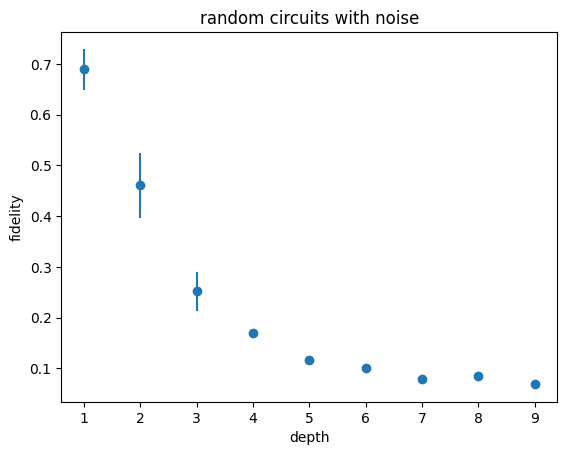

In [17]:
plt.errorbar(range(1,10), avgs, yerr=10*np.array(vars), fmt='o')
plt.xlabel('depth')
plt.ylabel('fidelity')
plt.title("random circuits with noise")

In [31]:
tfi = TFI(4, 1, 0.75)
times = np.arange(0.1, 5.1, 0.2)

avgs = []
vars = []
for num_steps in range(2,12):
    fid_samples = []
    for time in times: 
        step_size = time/num_steps
        circ = tfi.trotter_circ(step_size, num_steps, order=1)
        #print(len(circ.gate_list))
        exact_sim = DensityMatrixSim(circ, nm=None)
        exact_sim.run(progress_bar=False)
        exact_dm = exact_sim.get_density_matrix()

        sim = DensityMatrixSim(circ, nm=nm)
        sim.run(progress_bar=False)
        dm = sim.get_density_matrix()

        fid_samples.append(fidelity(dm, exact_dm))

    avgs.append(np.mean(fid_samples))
    vars.append(np.var(fid_samples))

Text(0.5, 1.0, 'TFI model with noise')

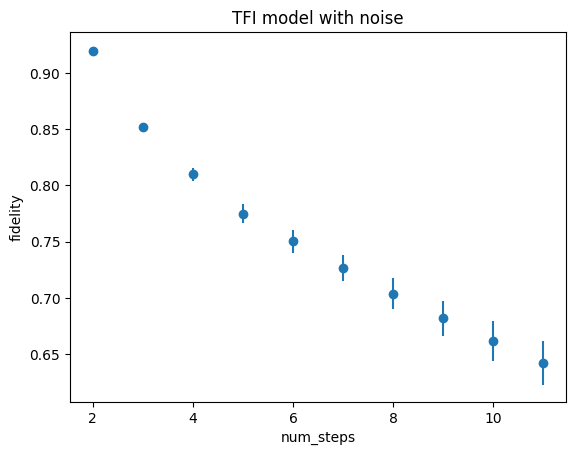

In [33]:
plt.errorbar(range(2,12), avgs, yerr=np.array(vars), fmt='o')
plt.xlabel('num_steps')
plt.ylabel('fidelity')
plt.title("TFI model with noise")

# Qubit vs Qutrit thermal noise

In [35]:
one_time = 40/1000 
two_time = 500/1000
t1 = 100
t2 = 75

nmb = QubitNoise(t1, t2, one_time, two_time)
nmt = QutritNoise(t1, t2, one_time, two_time)

In [36]:
n = 6
qubit_fidelities_6 = []
for t in np.arange(1, 100, 1):
    gate_list = [H(i) for i in range(n)] + [ID(2, t, i) for i in range(n)]
    circ = Circuit(gate_list, n)

    exact_sim = DensityMatrixSim(circ, nm=None)
    exact_sim.run(progress_bar=False)
    exact_dm = exact_sim.get_density_matrix()

    sim = DensityMatrixSim(circ, nm=nmb)
    sim.run(progress_bar=False)
    dm = sim.get_density_matrix()

    qubit_fidelities_6.append(fidelity(dm, exact_dm)) 

In [37]:
n = 6
qutrit_fidelities_6 = []
for t in np.arange(1, 100, 1):
    gate_list = [H01(i) for i in range(n)] + [ID(3, t, i) for i in range(n)]
    circ = Circuit(gate_list, n)

    exact_sim = DensityMatrixSim(circ, nm=None)
    exact_sim.run(progress_bar=False)
    exact_dm = exact_sim.get_density_matrix()

    sim = DensityMatrixSim(circ, nm=nmt)
    sim.run(progress_bar=False)
    dm = sim.get_density_matrix()

    qutrit_fidelities_6.append(fidelity(dm, exact_dm))  

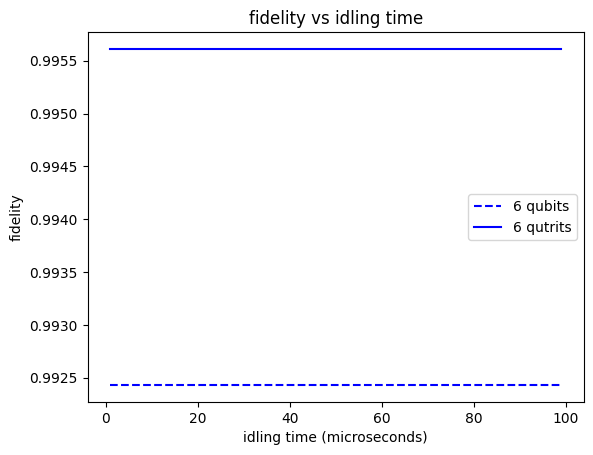

In [38]:
import matplotlib.pyplot as plt 

plt.plot(np.arange(1, 100, 1), qubit_fidelities_6, '--', color='b', label='6 qubits')
plt.plot(np.arange(1, 100, 1), qutrit_fidelities_6, color='b', label='6 qutrits')
plt.xlabel('idling time (microseconds)')
plt.ylabel('fidelity')
plt.title('fidelity vs idling time')
plt.legend()
plt.savefig('fidelity_vs_idling_time.pdf', bbox_inches='tight')

# partial trace

In [40]:
gate_list = [H(0), CNOT([1,0], 4), CNOT([2,1], 4), CNOT([3,2], 4)]
circ = Circuit(gate_list, 4) 
sim = StatevectorSim(circ) 
sim.run()
sv = sim.get_statevector()
rdm = rdm_from_sv(sv, [3], local_dim=2)
np.allclose(vN_entropy(rdm), np.log(2))

100%|██████████| 4/4 [00:00<?, ?it/s]


True

In [2]:
dm = random_dm(4)

dm_trial = partial_trace(dm, [1,0])
dm_true = np.einsum('ijklmnkl->ijmn', dm.reshape(*[2]*8)).reshape(4,4)
print(np.allclose(dm_trial, dm_true)) 

dm_trial = partial_trace(dm, [2,0], local_dim=2)
dm_true = np.einsum('ijklmjol->ikmo', dm.reshape(*[2]*8)).reshape(4,4)
print(np.allclose(dm_trial, dm_true))

dm_trial = partial_trace(dm, [1,3], local_dim=2)
dm_true = np.einsum('ijklinkp->jlnp', dm.reshape(*[2]*8)).reshape(4,4)
print(np.allclose(dm_trial, dm_true))

True
True
True


# less inefficient RDMs

In [3]:
sv = random_sv(4)

sites = [1,3]
dm = np.outer(sv, sv.conj())
rdm = partial_trace(dm, sites)
np.allclose(rdm, rdm_from_sv(sv, sites, local_dim=2))

True

# Does dynamical decoupling help? 

In [ ]:
n = 2
gate_list = [H(0)] * 20 + [H(1)]
circ = Circuit(gate_list, n)

t1 = 100
t2 = 75
one_qubit_time = 5
two_qubit_time = 50

nm1 = QubitNoise(t1, t2, one_qubit_time, two_qubit_time, coupling=1.0)
nm2 = QubitNoise(t1, t2, one_qubit_time, two_qubit_time, coupling=0.0)
circ1 = circ.build(nm=nm1)
circ2 = circ.build(nm=nm2)

sim0 = DensityMatrixSim(circ, nm=None)
sim1 = DensityMatrixSim(circ1, nm=nm1)
sim2 = DensityMatrixSim(circ2, nm=nm2)
 
sim0.run()
dm0 = sim0.get_density_matrix()

sim1.run()
dm1 = sim1.get_density_matrix()

sim2.run()
dm2 = sim2.get_density_matrix()

print('Fidelity without DD:', fidelity(dm1, dm0))
print('Fidelity with perfect DD:', fidelity(dm2, dm0))

100%|██████████| 20/20 [00:00<00:00, 169.20it/s]

Fidelity without DD: 0.3485278606391442
Fidelity with perfect DD: 0.40341841136137074
